**NLP Project - Mencarelli - Rodriguez - Zuna**

In [80]:
# Clone the repo
!git clone https://github.com/menca-lsn/NLP-Emotion-Classification

fatal: destination path 'NLP-Emotion-Classification' already exists and is not an empty directory.


In [156]:
import os

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras Components
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding, Dense, Flatten, Dropout, BatchNormalization,
    LSTM, Bidirectional, GRU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# PyTorch Components
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# HuggingFace Transformers
from transformers import (
    BertTokenizer, BertModel,
    AdamW, get_linear_schedule_with_warmup,
    AutoTokenizer, DataCollatorWithPadding
)

## Definition of a plot function for training result visualization

In [82]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

## Data Load

In [83]:
train_file_path = 'NLP-Emotion-Classification/data/train.txt'
validation_file_path = 'NLP-Emotion-Classification/data/validation.txt'
test_file_path = 'NLP-Emotion-Classification/data/test.txt'

In [84]:
# Reads the txt and divides X and Y by the semicolon
def load_data(file_path):
    X, Y = [], []
    with open(file_path, 'r') as file:
        for line in file:
            if ';' in line:
                parts = line.strip().split(';')
                if len(parts) == 2:
                    X.append(parts[0])
                    Y.append(parts[1])
    return X, Y

# Load datasets
X_train, Y_train = load_data(train_file_path)
X_validation, Y_validation = load_data(validation_file_path)
X_test, Y_test = load_data(test_file_path)

In [85]:
train_df = pd.DataFrame({'text': X_train, 'sentiment': Y_train})
validation_df = pd.DataFrame({'text': X_validation, 'sentiment': Y_validation})
test_df = pd.DataFrame({'text': X_test, 'sentiment': Y_test})

In [86]:
train_df['sentiment'].value_counts()

,count
sentiment,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [87]:
train_df.head()

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Data Preprocessing

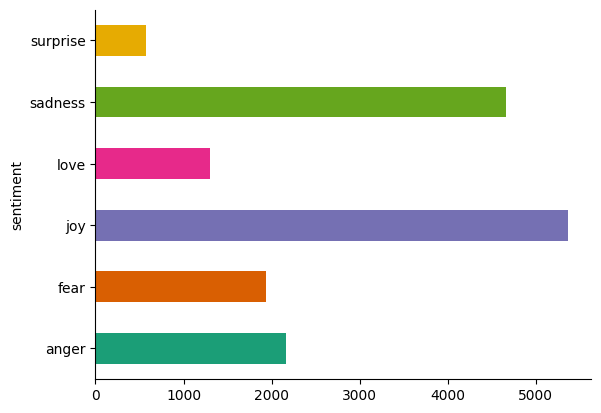

In [88]:
train_df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Note: Text looks like it's been already preprocessed (no punctuation marks, lowercase, etc)

In [89]:
# Tokenize the text data with OOV token
tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(train_df['text'].tolist())

# Convert texts to sequences
X_train = tokenizer.texts_to_sequences(train_df['text'].tolist())
X_validation = tokenizer.texts_to_sequences(validation_df['text'].tolist())
X_test = tokenizer.texts_to_sequences(test_df['text'].tolist())

# Calculate the lengths of the sequences before padding
train_lengths = [len(seq) for seq in X_train]
validation_lengths = [len(seq) for seq in X_validation]
test_lengths = [len(seq) for seq in X_test]

# Combine all lengths into one list
all_lengths = train_lengths + validation_lengths + test_lengths

# Calculate the 95th percentile
percentile_95 = np.percentile(all_lengths, 95)

# Print the result
print(f"The 95th percentile of sequence lengths is: {percentile_95}")

# Set max_length to the 95th percentile
max_length = int(percentile_95)

# Now, you can proceed with padding the sequences
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post')
X_validation_padded = pad_sequences(X_validation, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post')

# Encode labels and map to integers
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_df['sentiment'].tolist())

y_train = np.array(label_tokenizer.texts_to_sequences(train_df['sentiment'].tolist())) - 1
y_validation = np.array(label_tokenizer.texts_to_sequences(validation_df['sentiment'].tolist())) - 1
y_test = np.array(label_tokenizer.texts_to_sequences(test_df['sentiment'].tolist())) - 1

# Convert labels to one-hot encoding
num_classes = len(label_tokenizer.word_index)
y_train_categorical = to_categorical(y_train, num_classes)
y_validation_categorical = to_categorical(y_validation, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# Vocabulary size (includes padding and OOV token)
vocab_size = len(tokenizer.word_index) + 1

# Debugging and verification
print(f"Label Mapping: {label_tokenizer.word_index}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Sample Sequence: {train_df['text'][0]}")
print(f"Sample Sequence: {X_train_padded[0]}")


The 95th percentile of sequence lengths is: 41.0
Label Mapping: {'joy': 1, 'sadness': 2, 'anger': 3, 'fear': 4, 'love': 5, 'surprise': 6}
Vocabulary Size: 15214
Sample Sequence: i didnt feel humiliated
Sample Sequence: [  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]


#Model 1: Fully connected neural network

**Fully connected neural network**

In [108]:
# Define the Fully Connected Neural Network model
FCNN_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

# Compile the model
FCNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = FCNN_model.fit(X_train_padded, y_train_categorical, epochs=20, validation_data=(X_validation_padded, y_validation_categorical), callbacks=[early_stopping])


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2376 - loss: 5.8678 - val_accuracy: 0.3560 - val_loss: 2.3970
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3940 - loss: 2.3646 - val_accuracy: 0.6865 - val_loss: 1.8437
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7888 - loss: 1.5099 - val_accuracy: 0.7970 - val_loss: 1.5007
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8790 - loss: 1.1817 - val_accuracy: 0.7945 - val_loss: 1.5681
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9058 - loss: 1.1182 - val_accuracy: 0.8300 - val_loss: 1.4363
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9156 - loss: 1.0684 - val_accuracy: 0.8325 - val_loss: 1.4388
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9333 - loss: 1.0058 - val_accuracy: 0.8290 - val_loss: 1.4525


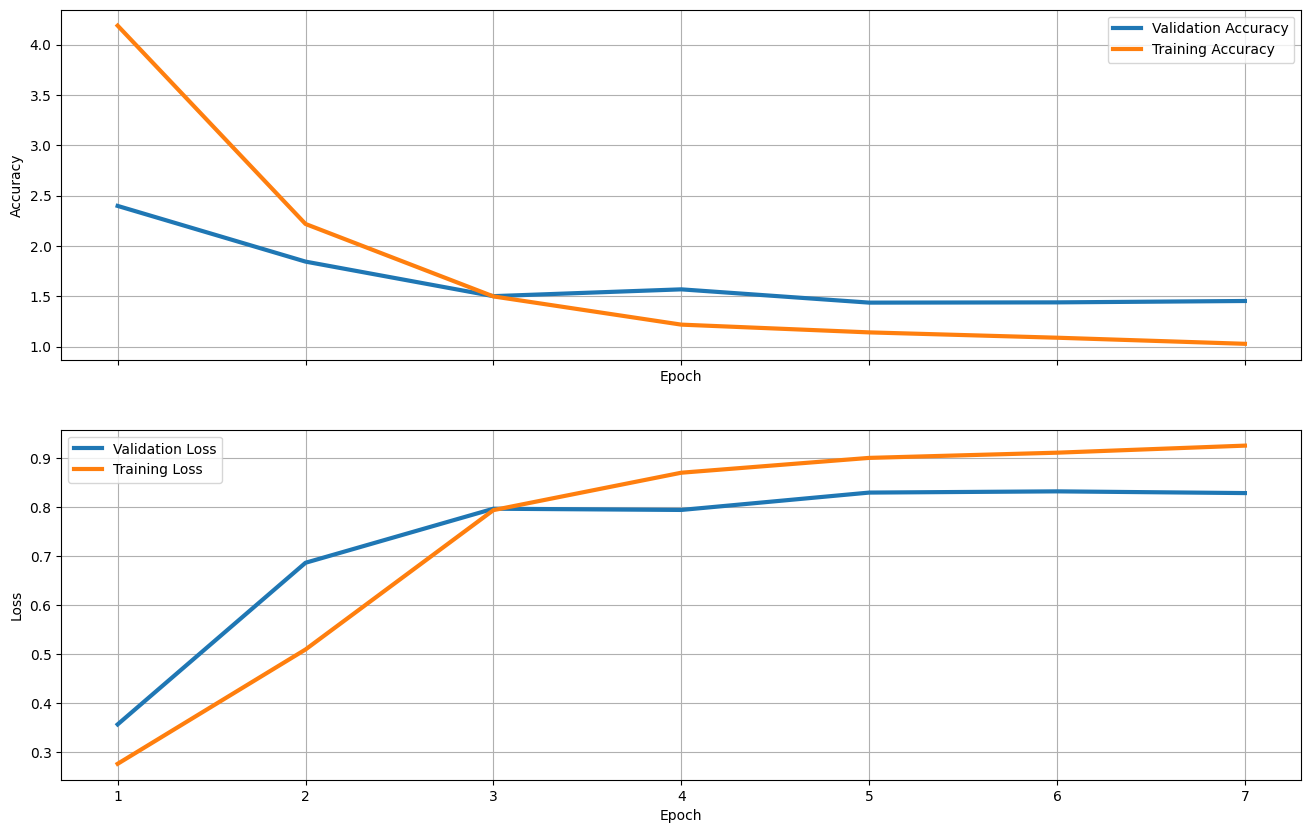

In [109]:
plot_results(history)

Evaluation

In [110]:
# Evaluate the model on the test data
loss, accuracy = FCNN_model.evaluate(X_test_padded, y_test_categorical)
print(f'Test Accuracy: {accuracy:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8158 - loss: 1.4588
Test Accuracy: 0.8135


In [155]:
# Save the FCNN model
FCNN_model.save("NLP-Emotion-Classification/models/fcnn_model.keras")

In [ ]:
# Load the FCNN model
loaded_fcnn_model = load_model("NLP-Emotion-Classification/models/fcnn_model.keras")

#Model 2: Recurrent Neural Network, based on LSTM

**LSTM Model**

In [132]:
# Define the LSTM model
LSTM_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model
LSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)

# Train the model
history = LSTM_model.fit(X_train_padded, y_train_categorical, epochs=30, validation_data=(X_validation_padded, y_validation_categorical), callbacks=[early_stopping])


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3216 - loss: 1.6058 - val_accuracy: 0.3520 - val_loss: 1.5865
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3293 - loss: 1.5876 - val_accuracy: 0.2750 - val_loss: 1.5889
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3257 - loss: 1.5844 - val_accuracy: 0.3520 - val_loss: 1.5806
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3268 - loss: 1.5843 - val_accuracy: 0.3755 - val_loss: 1.5497
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3296 - loss: 1.5898 - val_accuracy: 0.3520 - val_loss: 1.5888
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3356 - loss: 1.5735 - val_accuracy: 0.4095 - val_loss: 1.3618
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4387 - loss: 1.1763 - val_accuracy: 0.5245 - val_loss: 1.0164
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5886 - loss: 0.8430 - val_

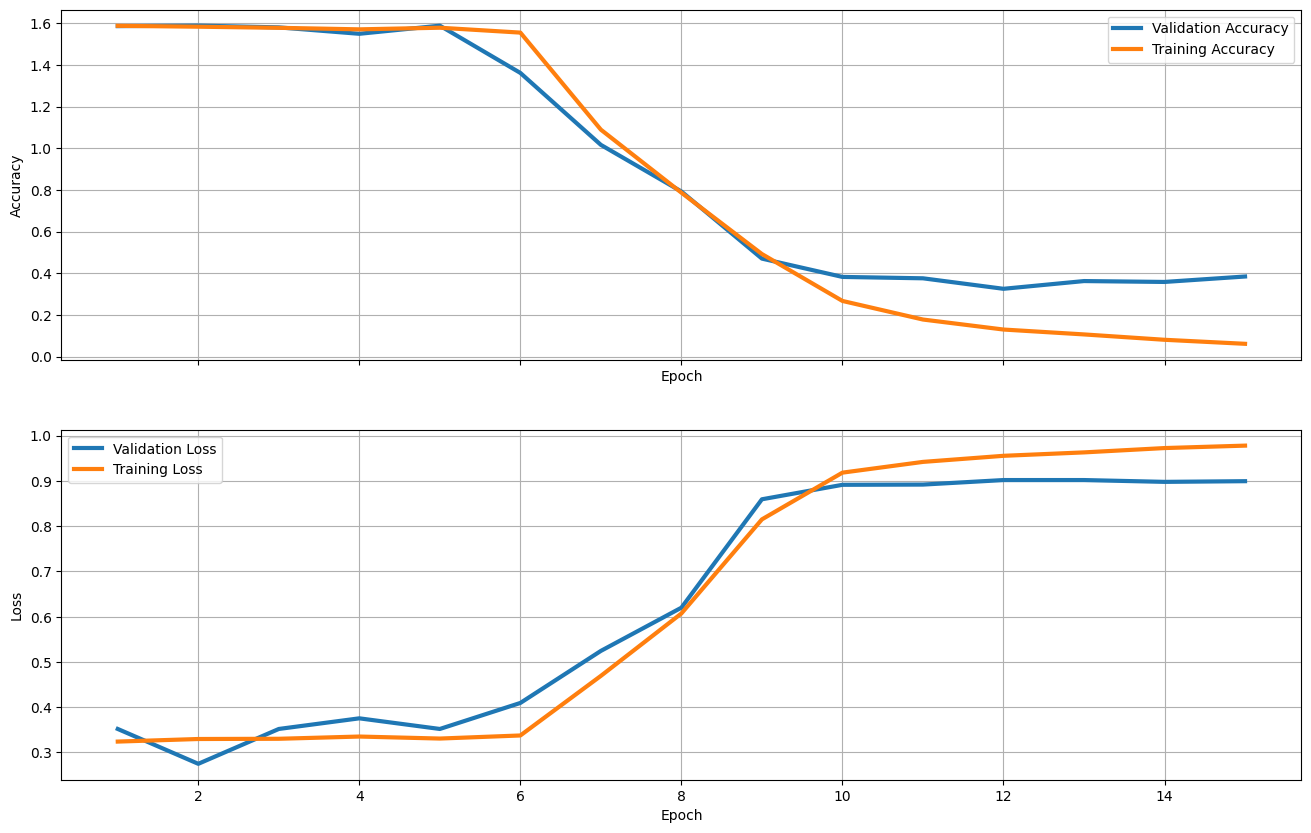

In [133]:
plot_results(history)

Evaluation

In [134]:
# Evaluate the model on the test data
loss, accuracy = LSTM_model.evaluate(X_test_padded, y_test_categorical)
print(f'Test Accuracy: {accuracy:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8937 - loss: 0.4039
Test Accuracy: 0.8935


In [154]:
# Save the LSTM model
LSTM_model.save("NLP-Emotion-Classification/models/rnn_model.keras")

In [ ]:
# Load the LSTM model
loaded_lstm_model = load_model("NLP-Emotion-Classification/models/rnn_model.keras")

# Model 3: Transformers finetuning

## Preprocessing

In [138]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [139]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [140]:
# Labels to numbers
sentiment_to_id = {sentiment: idx for idx, sentiment in enumerate(train_df['sentiment'].unique())}

train_df['sentiment'] = train_df['sentiment'].map(sentiment_to_id)
validation_df['sentiment'] = validation_df['sentiment'].map(sentiment_to_id)
test_df['sentiment'] = test_df['sentiment'].map(sentiment_to_id)

train_df.head()

,text,sentiment
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,1


In [141]:
#Create dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Helper functions

### Train function

In [142]:
def train_epoch(model, data_loader, optimizer, criterion, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

### Evaluate model function

In [143]:
def eval_model(model, data_loader, criterion, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

## Model definition

In [144]:
# Define model
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_classes=6):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.fc4 = nn.Linear(hidden_size//4, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

class BertClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = CustomClassifier(self.bert.config.hidden_size, hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [145]:
# HyperParameters
num_classes = len(sentiment_to_id)
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load Bert and set settings
bert_model = BertModel.from_pretrained('bert-base-uncased')

hidden_size = 256
Bert_classifier = BertClassifier(bert_model, hidden_size, num_classes)

Bert_classifier = Bert_classifier.to(device)

# Optimizer and loss function
optimizer = AdamW(Bert_classifier.parameters(), lr=LEARNING_RATE, correct_bias=False)
criterion = nn.CrossEntropyLoss().to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [146]:
# DataLoaders
train_dataset = TextDataset(
    texts=train_df['text'].to_numpy(),
    labels=train_df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = TextDataset(
    texts=validation_df['text'].to_numpy(),
    labels=validation_df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = TextDataset(
    texts=test_df['text'].to_numpy(),
    labels=test_df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [147]:
# learning rate
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Training

In [148]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        Bert_classifier,
        train_dataloader,
        optimizer,
        criterion,
        device,
        scheduler,
        len(train_df)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        Bert_classifier,
        val_dataloader,
        criterion,
        device,
        len(validation_df)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

Epoch 1/5
----------
Train loss 1.4993933072090149 accuracy 0.39225
Validation loss 0.9320009443759918 accuracy 0.708

Epoch 2/5
----------
Train loss 0.43811834429204466 accuracy 0.875
Validation loss 0.26317384517192843 accuracy 0.9175

Epoch 3/5
----------
Train loss 0.19377679364569486 accuracy 0.93225
Validation loss 0.204165582485497 accuracy 0.9265

Epoch 4/5
----------
Train loss 0.13074386630021034 accuracy 0.949375
Validation loss 0.1851906075887382 accuracy 0.9380000000000001

Epoch 5/5
----------
Train loss 0.1055815062248148 accuracy 0.9589375
Validation loss 0.17670388483256103 accuracy 0.936



## Evaluation

In [149]:
test_acc, _ = eval_model(
    Bert_classifier,
    test_dataloader,
    criterion,
    device,
    len(test_df)
)

print(f'Test Accuracy: {test_acc.item()}')

Test Accuracy: 0.9295


In [152]:
# Save the model state dictionary (weights and parameters)
model_path = 'NLP-Emotion-Classification/models/transformer_model/bert_classifier.pth'
torch.save(Bert_classifier.state_dict(), model_path)

# Save the entire model including architecture and weights
torch.save(Bert_classifier, 'NLP-Emotion-Classification/models/transformer_model/bert_classifier_full.pth')

In [ ]:
model_dir = 'models/transformer_model'

# To load the model weights:
Bert_classifier = BertClassifier(bert_model, hidden_size, num_classes)
Bert_classifier.load_state_dict(torch.load(model_path))
Bert_classifier = Bert_classifier.to(device)

# To load the entire model (including architecture and weights):
Bert_classifier = torch.load(os.path.join(model_dir, 'bert_classifier_full.pth'))
Bert_classifier = Bert_classifier.to(device)


# 4. Compare the different models to find the best approach and explained what you have learned from this exercise and how would you proceed with another text classification use case

When comparing our models, we can see that the RNN with LSTM and the Transformer performed the best. This makes sense because the FCNN is not designed for sequential data and does not capture dependencies between words. However, FCNNs are less computationally demanding and easier to train.

On the other hand, RNNs with LSTM are specifically designed for sequential tasks leading to significantly better accuracy. While they can still suffer from vanishing gradients it is not as severe as in basic RNNs. The Transformer captures long-term dependencies exceptionally well usually making it the best choice among the three. However, Transformers require a lot of computational resources and data to train effectively.

When starting a text classification project the first step should be to understand your data and preprocess it thoroughly. Begin with a simple model to establish a baseline and compare your results. Consider the balance between what you need in terms of accuracy and the resources available. This approach will help you choose the right model for your specific needs.

---
*Mencarelli - Rodriguez - Zuna*